# Approfondissement sur les distributions 1D - Solution

In [1]:
import openturns as ot
import numpy as np

## Solution de l'exercice 1 : produit

Il existe une singularité en zéro. Cependant, si la densité de probabilité n'est pas évaluée à la singularité, cela ne pose pas de problème. C'est pourquoi nous fixons le nombre de points à un nombre pair.

**Références**

- [Is algebra of random variables commutative? (OpenTURNS Discourse)](https://openturns.discourse.group/t/is-algebra-of-random-variables-commutative/72/2)

In [2]:
u = ot.Uniform(0.0, 1.0)
n = ot.Normal(0.0, 1.0)
z = u * n
z.setDescription(["U * N"])  # Optional
z


class=ProductDistribution name=ProductDistribution left=class=Uniform name=Uniform dimension=1 a=0 b=1 right=class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

In [3]:
print(z)

ProductDistribution(Uniform(a = 0, b = 1) * Normal(mu = 0, sigma = 1))


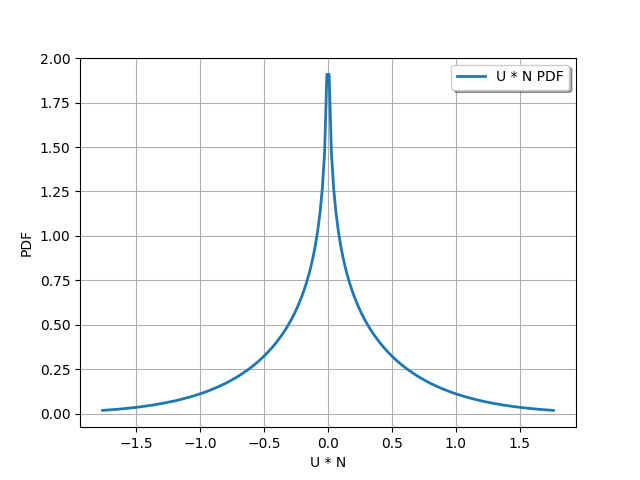

In [4]:
z.drawPDF(200)  # Singularity

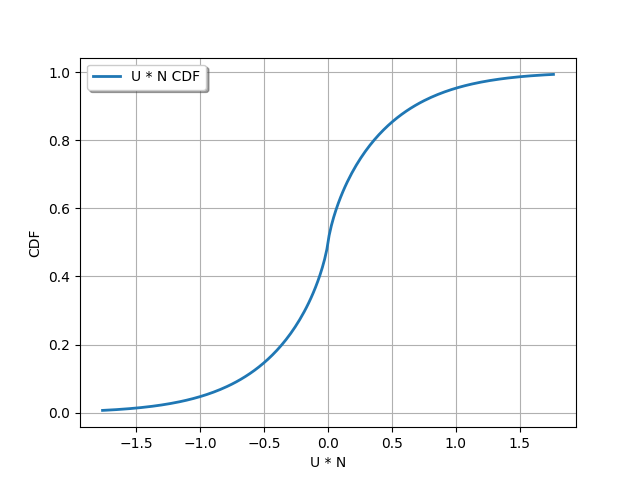

In [5]:
z.drawCDF(200)

## Solution de l'exercice 2 : poutre sollicitée axialement

**1. Création de la charge de traction $F$.**

Créer la variable `F` suivant une loi normale 1D.

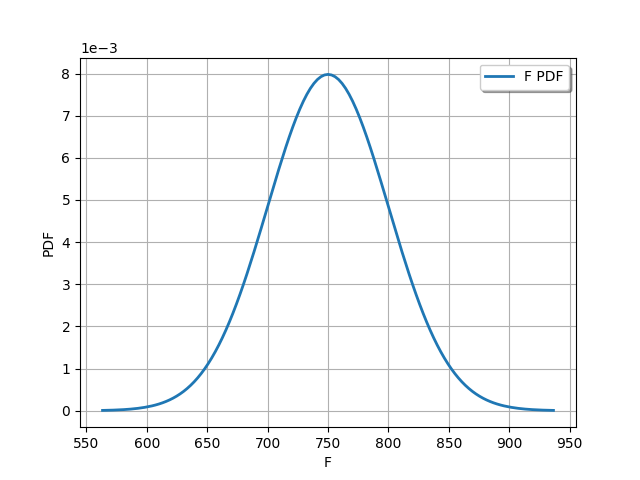

In [6]:
F = ot.Normal(750.0, 50.0)
F.setName("Traction_load")
F.setDescription("F")

F.drawPDF()

**2. Création de la résistance $R$**

Créer la variable `R` définie comme une loi LogNormale 1D, paramétrée par sa moyenne et son écart-type.

In [7]:
parameters = ot.LogNormalMuSigma(3.0e6, 3.0e5, 0.0)
R = parameters.getDistribution()
R.setName("Yield strength")
R.setDescription("R")
R

class=LogNormal name=Yield strength dimension=1 muLog=14.9091 sigmaLog=0.0997513 gamma=0

In [8]:
R.getStandardDeviation()

class=Point name=Unnamed dimension=1 values=[300000]

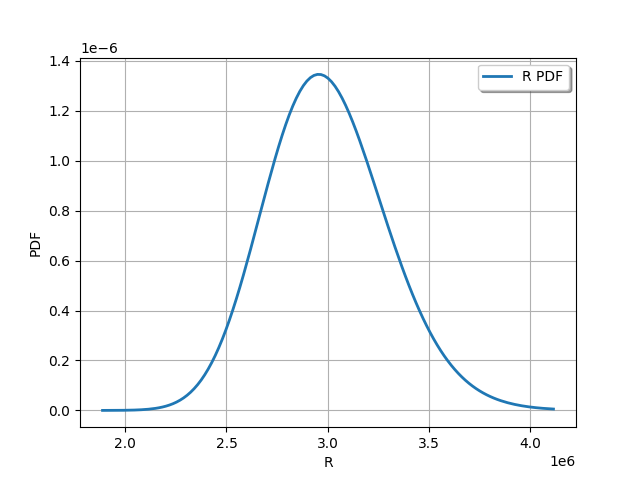

In [9]:
R.drawPDF()

**3. Définition des paramètres déterministes et de la fonction d'état limite**

Le diamètre $D$ est fixé à $0.02$ m. On définit ensuite la variable aléatoire de sortie $Y = g(R, F)$ en utilisant les opérateurs arithmétiques.

In [10]:
D = 0.02
# Calcul de la contrainte et de la marge de sécurité
Y = R - F / (np.pi * D**2 / 4)
print(Y)

RandomMixture(LogNormal(muLog = 14.9091, sigmaLog = 0.0997513, gamma = 0) + Normal(mu = -2.38732e+06, sigma = 159155))


**Remarque.** On observe que la différence de deux variables aléatoires est implémentée avec la classe `ot.RandomMixture`. Cette classe est spécifiée par une collection de variables aléatoires indépendantes et une collection de poids. Ici, les poids sont égaux à 1 et les distributions sont `F` et `F / (np.pi * D**2 / 4)`.

**Note.** La classe `RandomMixture` est mal nommée dans la bibliothèque (voir [RandomMixture has a wrong name #3072](https://github.com/openturns/openturns/issues/3072)). En effet, dans le contexte du calcul des probabilités, une loi de mélange est une distribution associée au processus suivant. D'abord, on choisit aléatoirement une distribution en tenant compte des poids. Puis on génère une observation correspondant la distribution sélectionnée. Dans la bibliothèque, la classe `RandomMixture` implémente une combinaison linéaire de variables aléatoires indépendantes.

**4. Calcul de la probabilité de défaillance**

Finalement, nous calculons la probabilité avec la méthode `computeCDF()`.

In [11]:
pf = Y.computeCDF(0.0)
pf

0.0291981946248305

On souhaite visualiser les couples $(R, F)$ qui mènent à la défaillance. Le script suivant génère un échantillon de taille 200.

In [12]:
inputDistribution = ot.JointDistribution((R, F))
g = ot.SymbolicFunction(["R", "F", "D"], ["R - F / (pi_ * D^2 / 4)"])
gParametric = ot.ParametricFunction(g, [2], [D])
sampleSize = 200
inputSample = inputDistribution.getSample(sampleSize)
outputSample = gParametric(inputSample)

Le script suivant permet de visualiser les points sûrs et les points en échec.

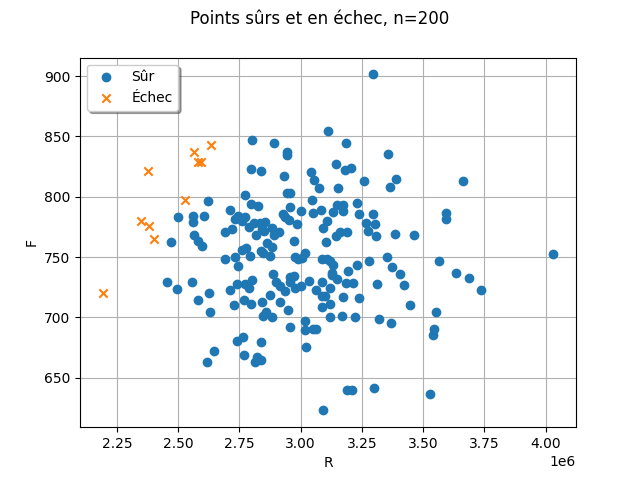

In [13]:
graph = ot.Graph(f"Points sûrs et en échec, n={sampleSize}", "R", "F", True)
# Points sûrs
safe_indices = [i for i in range(inputSample.getSize()) if outputSample[i, 0] > 0]
cloud = ot.Cloud(inputSample[safe_indices])
cloud.setLegend("Sûr")
cloud.setPointStyle("o")
graph.add(cloud)
# Points en échec
failed_indices = [i for i in range(inputSample.getSize()) if outputSample[i, 0] < 0]
cloud = ot.Cloud(inputSample[failed_indices])
cloud.setLegend("Échec")
cloud.setPointStyle("x")
graph.add(cloud)
#
graph.setLegendPosition("upper left")
graph

## Solution de l'exercice 3 : une autre distribution uniforme

Dans l'exemple suivant, nous définissons la distribution `U`, grâce à une implémentation alternative de la loi uniforme. Cette fois-ci, nous ne définissons que la méthode `computeCDF()`.

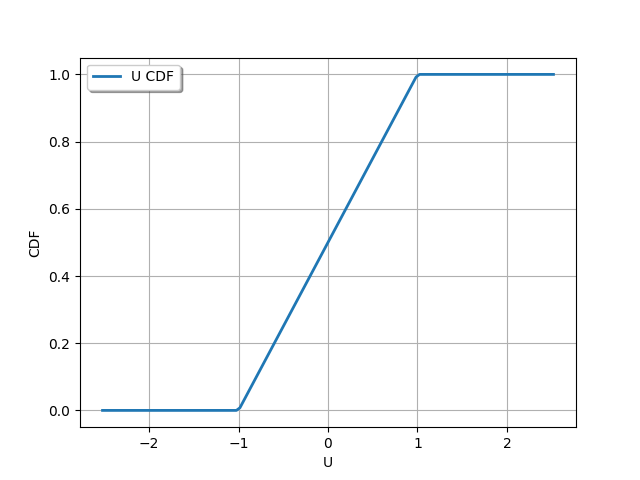

In [14]:
class UDistribution(ot.PythonDistribution):
    def __init__(self, a, b):
        super().__init__(1)
        self.a = a
        self.b = b

    def computeCDF(self, x):
        u = x[0]
        if u <= self.a:
            p = 0.0
        elif u < self.b:
            p = (u - self.a) / (self.b - self.a)
        else:
            p = 1.0
        return p
    
    def getRange(self):
        return ot.Interval([self.a], [self.b])


U = ot.Distribution(UDistribution(-1.0, 1.0))
U.setDescription(["U"])

U.drawCDF()

La méthode `drawPDF()` trace la densité de probabilité. Cela nécessite la dérivée, qui est approximée par différences finies de la fonction de répartition.

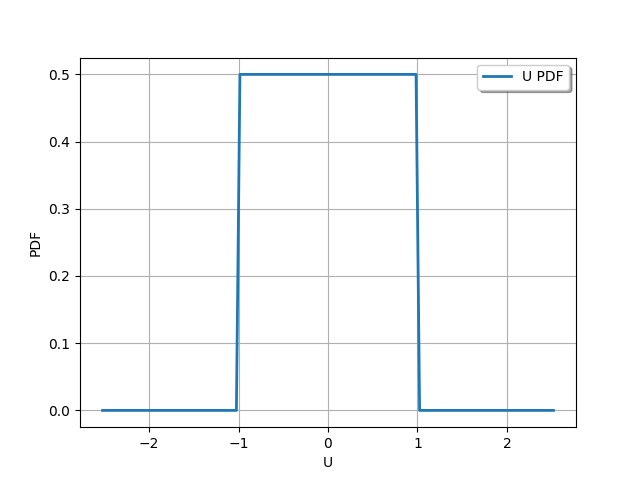

In [15]:
U.drawPDF()

In [16]:
U.getRange()

class=Interval name=Unnamed dimension=1 lower bound=class=Point name=Unnamed dimension=1 values=[-1] upper bound=class=Point name=Unnamed dimension=1 values=[1] finite lower bound=[1] finite upper bound=[1]

Il n'est pas strictement nécessaire d'implémenter la méthode `getRange()`. Par défaut, la classe `PythonDistribution` calcule l'intervalle contenant une masse probabiliste significative. Pour cela, elle inverse la fonction de répartition grâce à une méthode numérique. Toutefois, implémenter la méthode `getRange()` est ici extrêmement facile et donc il est bénéfique de le faire à la fois pour des raisons de performance et de précision.

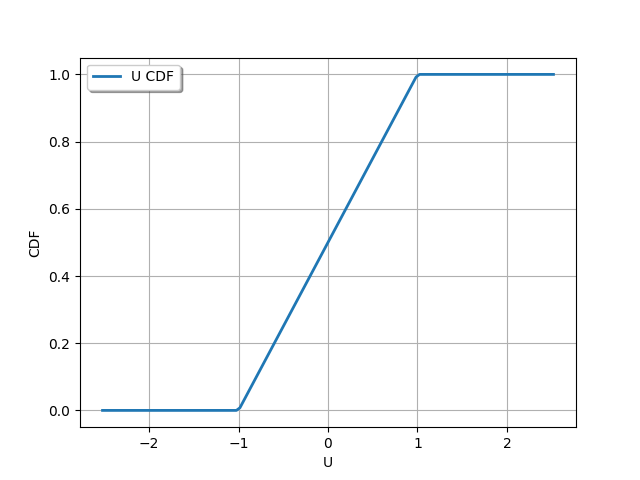

In [17]:
class UDistribution(ot.PythonDistribution):
    def __init__(self, a, b):
        super().__init__(1)
        self.a = a
        self.b = b

    def computeCDF(self, x):
        u = x[0]
        if u <= self.a:
            p = 0.0
        elif u < self.b:
            p = (u - self.a) / (self.b - self.a)
        else:
            p = 1.0
        return p

    def getRange(self):
        return ot.Interval(self.a, self.b)

U = ot.Distribution(UDistribution(-1.0, 1.0))
U.setDescription(["U"])

U.drawCDF()

## Solution de l'exercice 4 : un débit positif

Le débit $Q$ est modélisé par une loi de Gumbel (échelle = 500, mode = 900). Pour respecter la physique du problème (débit strictement positif), nous appliquons une troncature inférieure à zéro.

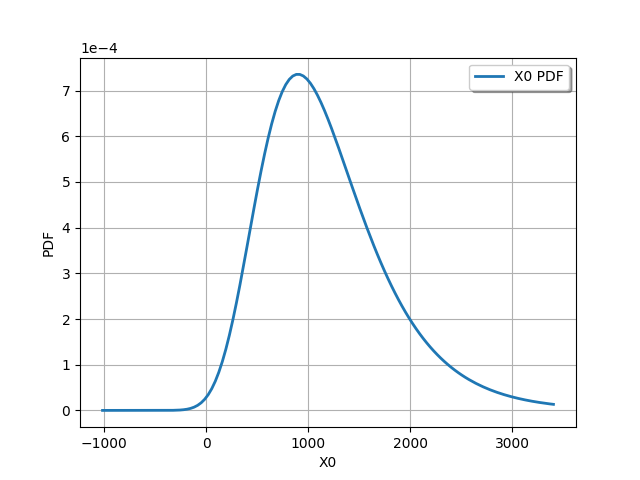

In [18]:
Quntruncated = ot.Gumbel(500.0, 900.0)
Quntruncated.drawPDF()

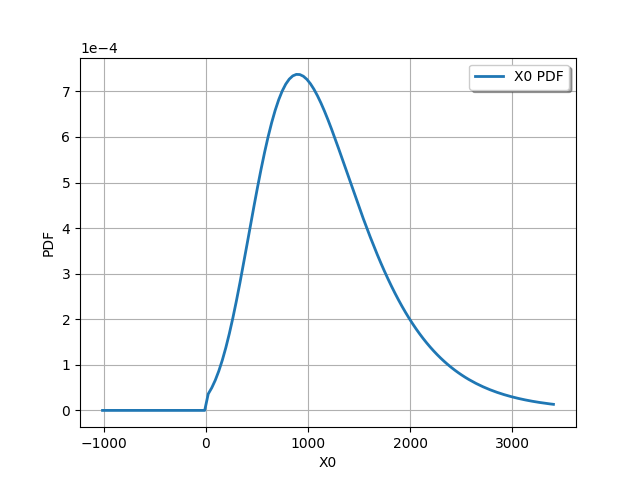

In [19]:
Q = ot.TruncatedDistribution(Quntruncated, 0.0, ot.TruncatedDistribution.LOWER)
Q.drawPDF()

**Observation :** 

On remarque une discontinuité de la densité de probabilité à l'origine ($Q=0$), ce qui est caractéristique des distributions tronquées dont la masse de probabilité initiale en dehors de l'intervalle est non nulle.